In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as splin
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.colors import LinearSegmentedColormap
import tensorflow as tf
import _pickle as pickle
from sklearn.manifold import TSNE
import scipy.linalg as splin

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def plotProjections(projections, clist, gridsize=2):
    xsize = 8
    ysize = 8
    figs, axs = plt.subplots(nrows = gridsize, ncols = gridsize, figsize=(4*xsize,4*ysize))
    for row in range(gridsize):
        for col in range(gridsize):
            if col >= row:
                if col == row:
                    sortIndex = row+2
                else:
                    sortIndex = row+1
                py = projections[:,row]
                px = projections[:,col+1]
                sorting = projections[:,sortIndex].argsort()
                
                CLIST = np.array(clist)[sorting]
                PX = px[sorting]
                PY = py[sorting]
                
                rangeX = PX.max() - PX.min()
                centerX = (PX.max() + PX.min())/2.0
                rangeY = PY.max() - PY.min()
                centerY = (PY.max() + PY.min())/2.0
                axesDist = 0.6*max(rangeX,rangeY)
                
                sc1 = axs[row,col].scatter(PX,PY,alpha=0.7,c=CLIST)
                
                subTitle = str(row+1) + ' vs. ' + str(col+2)
                
                axs[row,col].set_title(subTitle)
                axs[row,col].set_xlim([centerX - axesDist, centerX + axesDist])
                axs[row,col].set_ylim([centerY - axesDist, centerY + axesDist])
                axs[row,col].ticklabel_format(style='sci', scilimits=(-2,2),axis='both')
            else:
                axs[row,col].axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
def saveThing(thing,file):
    with open(file,'wb') as fil:
        pick = pickle.Pickler(fil)
        pick.dump(thing)
        pick.clear_memo()
        
def openThing(file,py2 = False):
    if py2:
        with open(file,'rb') as fil:
            u = pickle._Unpickler(fil)
            u.encoding = 'latin1'
            thing = u.load()
    else:
        with open(file,'rb') as fil:
            thing = pickle.load(fil)
    return thing


MNIST plots

In [5]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [6]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

W_conv1 = weight_variable([5,5,1,32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x,[-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image,W_conv1)+b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1,W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7*7*64,1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2,[-1,7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat,W_fc1) + b_fc1)

W_fc2 = weight_variable([1024,10])
b_fc2 = bias_variable([10])

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1,keep_prob)

y_conv = tf.matmul(h_fc1_drop,W_fc2) + b_fc2

In [7]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

accuraciesTraining = []
accuraciesTest = []
allProbs = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
    #test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
    #print('Initializing, training accuracy %g' % (train_accuracy))
    #accuraciesTraining.append([-1, train_accuracy])
    #accuraciesTest.append([-1, test_accuracy])
    #probs_estimators = y_conv.eval(feed_dict={x: mnist.test.images, keep_prob:1.0},session=sess)
    #allProbs.append(np.array([[np.exp(x)/sum([np.exp(y) for y in prob]) for x in prob] for prob in probs_estimators]))
    for i in range(2000):
        batch = mnist.train.next_batch(3000)
        if (i % 10 == 0) or (i < 10):
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
            test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
            accuraciesTraining.append([i, train_accuracy])
            accuraciesTest.append([i, test_accuracy])
            if (i % 100 == 0) or (i < 100):
                probs_estimators = y_conv.eval(feed_dict={x: mnist.test.images, keep_prob:1.0},session=sess)
                allProbs.append(np.array([[np.exp(x)/sum([np.exp(y) for y in prob]) for x in prob] for prob in probs_estimators]))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    probs_estimators = y_conv.eval(feed_dict={x: mnist.test.images, keep_prob:1.0},session=sess)
    allProbs.append(np.array([[np.exp(x)/sum([np.exp(y) for y in prob]) for x in prob] for prob in probs_estimators]))

step 0, training accuracy 0.132333
step 1, training accuracy 0.141
step 2, training accuracy 0.175667
step 3, training accuracy 0.176667
step 4, training accuracy 0.156667
step 5, training accuracy 0.17
step 6, training accuracy 0.158667
step 7, training accuracy 0.164
step 8, training accuracy 0.159667
step 9, training accuracy 0.190333
step 10, training accuracy 0.225
step 20, training accuracy 0.587667
step 30, training accuracy 0.774333
step 40, training accuracy 0.828333
step 50, training accuracy 0.869333
step 60, training accuracy 0.892333
step 70, training accuracy 0.896333
step 80, training accuracy 0.917333
step 90, training accuracy 0.924
step 100, training accuracy 0.931333
step 110, training accuracy 0.933
step 120, training accuracy 0.937
step 130, training accuracy 0.941667
step 140, training accuracy 0.951
step 150, training accuracy 0.946333
step 160, training accuracy 0.956667
step 170, training accuracy 0.954333
step 180, training accuracy 0.957333
step 190, training

In [12]:
saveThing(accuraciesTraining,'accuraciesTraining.pckl')
saveThing(accuraciesTest,'accuraciesTest.pckl')

In [39]:
saveThing(allProbs,'allProbs.pckl')

In [ ]:
len(allProbs)

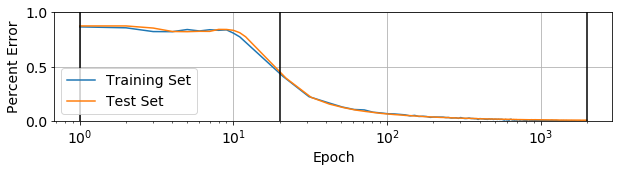

In [54]:
plt.figure(figsize=(10,2))
plt.plot([x+1 for x,y in accuraciesTraining],[1-y for x,y in accuraciesTraining],label='Training Set')
plt.plot([x+2 for x,y in accuraciesTest],[1-y for x,y in accuraciesTest],label='Test Set')

plt.plot([1,1],[0.0001,2],c='black')
#plt.plot([10,10],[0.0001,2],c='black')
plt.plot([20,20],[0.0001,2],c='black')
#plt.plot([500,500],[0.0001,2],c='black')
plt.plot([2000,2000],[0.0001,2],c='black')

#plt.xticks(np.linspace(0,100,21))

plt.legend(loc='lower left',fontsize=14)

#plt.grid()

#plt.yscale('log')
plt.xscale('log')
#plt.ylim([10**(-4),2])

plt.xticks([1,10,100,1000],fontsize=14)
plt.yticks([0,0.5,1],fontsize=14)

plt.ylim([0,1])

plt.grid()

#plt.xlim([-10,2010])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Percent Error',fontsize=14)

plt.show()

In [51]:
counts = [[0,-1]]
idx = 0
for i in range(2001):
    if (i % 10 == 0) or (i < 10):
        if (i % 100 == 0) or (i < 100):
            idx += 1
            counts.append([idx,i])

In [52]:
len(counts)

40

In [53]:
counts

[[0, -1],
 [1, 0],
 [2, 1],
 [3, 2],
 [4, 3],
 [5, 4],
 [6, 5],
 [7, 6],
 [8, 7],
 [9, 8],
 [10, 9],
 [11, 10],
 [12, 20],
 [13, 30],
 [14, 40],
 [15, 50],
 [16, 60],
 [17, 70],
 [18, 80],
 [19, 90],
 [20, 100],
 [21, 200],
 [22, 300],
 [23, 400],
 [24, 500],
 [25, 600],
 [26, 700],
 [27, 800],
 [28, 900],
 [29, 1000],
 [30, 1100],
 [31, 1200],
 [32, 1300],
 [33, 1400],
 [34, 1500],
 [35, 1600],
 [36, 1700],
 [37, 1800],
 [38, 1900],
 [39, 2000]]

Plotting Data

In [ ]:
probs = np.array([[np.exp(x)/sum([np.exp(y) for y in prob]) for x in prob] for prob in probs_estimators])

In [ ]:
def findProj(data,eigs=4):
    data = np.array(data)
    DDT = np.log(np.dot(data,data.T))
    DDT_sums = np.array([sum(row)/len(data) for row in DDT])
    DDT_sum_sums = sum(DDT_sums)/len(data)
    DDT_PCA = np.array([[DDT[i][j] - DDT_sums[i] - DDT_sums[j] + DDT_sum_sums for i in range(len(data))] for j in range(len(data))])
    
    wR,vRt = splin.eigh(DDT_PCA,eigvals=(len(DDT)-1-eigs,len(DDT)-1))
    wI,vIt = splin.eigh(DDT_PCA,eigvals=(0,eigs))
    
    W = list(wR)
    W.extend(list(wI))
    W = np.array(W)
    sorting = abs(np.array(W)).argsort()[::-1]
    
    V = list(vRt.T)
    V.extend(list(vIt.T))
    V = np.array(V)
    
    W = W[sorting]
    V = V[sorting]
    
    imCol = []
    for i in range(len(W)):
        if W[i] < 0:
            imCol.append(i)
            
    proj = np.dot(V.T,np.diag(np.sqrt(np.abs(W))))
    
    return(proj,imCol)

In [ ]:
proj,imCol = findProj(np.sqrt(probs),eigs=4)

In [ ]:
saveThing(proj,'proj.pckl')
saveThing(probs,'probs.pckl')

In [ ]:
colors = ['C'+str(i) for i in range(10)]
clist = []
labels = []
for label in mnist.test.labels:
    for e in range(10):
        if label[e] == 1:
            clist.append(colors[e])
            labels.append(e)
saveThing(labels,'labels.pckl')

In [ ]:
#3D plots
px = proj[:,0]
py = proj[:,1]
pz = proj[:,2]

mean_x = px.min()
mean_y = py.min()
mean_z = pz.min()

Xdist = px.max() - px.min()
Xcntr = (px.max() + px.min())/2.0
Ydist = py.max() - py.min()
Ycntr = (py.max() + py.min())/2.0
Zdist = pz.max() - pz.min()
Zcntr = (pz.max() + pz.min())/2.0

dist = 0.5*max(Xdist,Ydist,Zdist)

fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
#ax.view_init(30,-60)

listTemp = [i for i in range(len(proj))]

ax.scatter(px,py,pz,c=clist,edgecolor='black',linewidth=0.2)

ax.set_xlim([Xcntr - dist, Xcntr + dist])
ax.set_ylim([Ycntr - dist, Ycntr + dist])
ax.set_zlim([Zcntr - dist, Zcntr + dist])

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

arrowSize=2*dist/5

vects = [[mean_x+arrowSize,mean_y,mean_z],[mean_x,mean_y+arrowSize,mean_z],[mean_x,mean_y,mean_z+arrowSize]]

for v in vects:
    a = Arrow3D([mean_x,v[0]],[mean_y,v[1]],
                [mean_z,v[2]],mutation_scale=20,
                lw=3,arrowstyle="-|>",color="r")
    ax.add_artist(a)
ax.set_axis_off()

In [ ]:
X = -2*np.log(np.dot(probs,probs.T))

In [ ]:
X_embedded=TSNE(n_components=3).fit_transform(X)

In [ ]:
sampleDigits = mnist.test.images[[3,2,1,30,19,15,21,0,61,16]]

In [ ]:
for image in sampleDigits:
    plt.imshow([image[28*i:28*(i+1)] for i in range(28)],cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
saveThing(sampleDigits,'sampleDigits.pckl')

In [ ]:
probs = openThing('probs.pckl')
labels = openThing('labels.pckl')

In [ ]:
def klDiv(p1,p2):
    return sum(p1*np.log(p1)-p1*np.log(p2) + p2*np.log(p2)-p2*np.log(p1))

In [ ]:
distances = [[-8*np.log(np.dot(np.sqrt(p1),np.sqrt(p2))) for p1 in probs] for p2 in probs]

In [ ]:
distances = abs(np.array(distances))

In [ ]:
X_embedded = TSNE(n_components=3).fit_transform(distances)

In [ ]:
klDistances = [[klDiv(p1,p2) for p1 in probs] for p2 in probs]

In [ ]:
X_kl = TSNE(n_components=3).fit_transform(klDistances)

In [ ]:
X_kl2D = TSNE(n_components=2).fit_transform(klDistances)

In [ ]:
X_euclid = TSNE(n_components=3,init='pca').fit_transform(probs)

In [ ]:
#3D plots
proj = X_kl2D

px = proj[:,0]
py = proj[:,1]
pz = proj[:,2]

mean_x = px.min()
mean_y = py.min()
mean_z = pz.min()

Xdist = px.max() - px.min()
Xcntr = (px.max() + px.min())/2.0
Ydist = py.max() - py.min()
Ycntr = (py.max() + py.min())/2.0
Zdist = pz.max() - pz.min()
Zcntr = (pz.max() + pz.min())/2.0

dist = 0.5*max(Xdist,Ydist,Zdist)

fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
#ax.view_init(30,-60)

ax.scatter(px,py,pz,c=clist,edgecolor='black',linewidth=0.2)

ax.set_xlim([Xcntr - dist, Xcntr + dist])
ax.set_ylim([Ycntr - dist, Ycntr + dist])
ax.set_zlim([Zcntr - dist, Zcntr + dist])

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()

In [ ]:
saveThing(X_kl2D,'tsneKL2D.pckl')

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(X_kl2D[:,0],X_kl2D[:,1],c=clist,edgecolor='black',linewidth=0.2)
plt.axis('equal')
plt.show()

In [ ]:
plotProjections(proj0,clist,gridsize=4)

In [ ]:
plotProjections(proj12,clist,gridsize=2)

In [ ]:
plotProjections(proj49,clist,gridsize=4)

In [ ]:
plt.scatter(proj1[:,1],proj1[:,2],c=clist)
plt.show()

In [ ]:
plt.scatter(proj12[:,1],proj12[:,2],c=clist)
plt.show()

In [ ]:
len(proj0)